In [11]:
# Import Dependencies
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import seaborn as sns


In [2]:
# Define paths to the dataset
train_dir = 'ASL_Alphabet_Dataset/asl_alphabet_train'
test_dir = 'ASL_Alphabet_Dataset/asl_alphabet_test'

# Data Processing

In [31]:
# Process images and store them in a pickle file
def process_images(train_dir, output_file, fixed_length=63):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)
    data = []
    labels = []

    # List all directories and files in the training directory
    all_files = [(os.path.join(train_dir, dir_, img), dir_)
                 for dir_ in os.listdir(train_dir)
                 for img in os.listdir(os.path.join(train_dir, dir_))]

    # Process each image in the training directory with a progress tracker
    for img_path, dir_ in tqdm(all_files, desc="Processing images", unit="image"):
        img = cv2.imread(img_path)
        if img is not None:
            # Resize image to a consistent size
            img_resized = cv2.resize(img, (256, 256))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                data_aux = []
                for hand_landmarks in results.multi_hand_landmarks:
                    for landmark in hand_landmarks.landmark:
                        data_aux.extend([landmark.x, landmark.y, landmark.z])
                # Pad or trim the sequence to the fixed length
                if len(data_aux) > fixed_length * 3:
                    data_aux = data_aux[:fixed_length * 3]
                data_padded = pad_sequences([data_aux], maxlen=fixed_length * 3, padding='post', dtype='float32')[0]
                data.append(data_padded)
                labels.append(dir_)

    # Convert to numpy arrays for consistency
    data = np.array(data)
    labels = np.array(labels)

    # Save the data to a pickle file
    with open(output_file, 'wb') as f:
        pickle.dump((data, labels), f)

# Process the images with a fixed length
process_images(train_dir, 'sign_language_data_recaptured_fixed.pkl', fixed_length=63)



Processing images:   0%|          | 0/223074 [00:00<?, ?image/s]c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing images: 100%|██████████| 223074/223074 [1:06:51<00:00, 55.61image/s]


Number of samples: 165200
First sample data: [ 4.6447861e-01  7.0558661e-01 -4.8384669e-07  5.5534607e-01
  6.5801132e-01 -2.8512118e-02  6.1018068e-01  5.5440271e-01
 -3.4414705e-02  6.2641186e-01  4.7107089e-01 -4.1871581e-02
  6.5442502e-01  4.1293207e-01 -4.3473486e-02  5.6128544e-01
  4.7989240e-01 -6.2501444e-03  5.7963783e-01  4.2889512e-01
 -5.5979587e-02  5.6777930e-01  4.9454448e-01 -8.0622442e-02
  5.5723196e-01  5.5022407e-01 -8.6056180e-02  4.9986461e-01
  4.8057070e-01 -6.9559985e-03  5.2204365e-01  4.3763733e-01
 -6.6882491e-02  5.2031064e-01  5.1933670e-01 -8.0627821e-02
  5.2096796e-01  5.8641273e-01 -7.0930965e-02  4.4136024e-01
  4.8998904e-01 -1.6111534e-02  4.6563646e-01  4.8678270e-01
 -7.8138791e-02  4.7670761e-01  5.7502854e-01 -7.6016620e-02
  4.8682660e-01  6.3493383e-01 -5.2802980e-02  3.8416460e-01
  5.0785947e-01 -2.7318511e-02  4.1660178e-01  5.1367545e-01
 -6.8087392e-02  4.3594605e-01  5.7867938e-01 -6.6675447e-02
  4.4929695e-01  6.2032938e-01 -5.134534

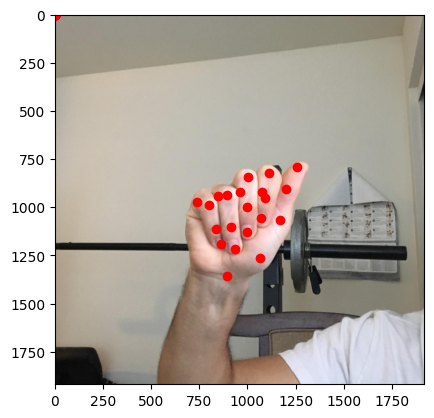

In [10]:
# Load data from pickle file
with open('sign_language_data_recaptured_fixed.pkl', 'rb') as f:
    data, labels = pickle.load(f)

# Inspect the data
print("Number of samples:", len(data))
print("First sample data:", data[0])
print("First sample label:", labels[0])

# Function to visualize landmarks on an image
def visualize_landmarks(img_path, landmarks):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    for i in range(0, len(landmarks), 3):
        x = landmarks[i] * img.shape[1]
        y = landmarks[i + 1] * img.shape[0]
        plt.scatter(x, y, c='r', marker='o')
    plt.show()

# Visualize the first sample's landmarks on its image
first_img_path = os.path.join(train_dir, labels[0], os.listdir(os.path.join(train_dir, labels[0]))[0])
visualize_landmarks(first_img_path, data[0])



# Model Training

In [5]:
# Load data from pickle file
with open('sign_language_data_recaptured_fixed.pkl', 'rb') as f:
    data, labels = pickle.load(f)

# Convert labels to numpy array
labels = np.array(labels)

# Normalize data (coordinates are assumed to be in the range 0-1)
data = np.array(data)

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42)

# Reshape data to add a channel dimension
X_train = X_train.reshape((X_train.shape[0], 63, 3, 1))
X_test = X_test.reshape((X_test.shape[0], 63, 3, 1))

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(63, 3, 1)),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Save the model
model.save('asl_model_tuned.keras')



Epoch 1/30


c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.6706 - loss: 1.2110 - val_categorical_accuracy: 0.9403 - val_loss: 0.2376
Epoch 2/30
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9494 - loss: 0.2027 - val_categorical_accuracy: 0.9547 - val_loss: 0.1772
Epoch 3/30
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9642 - loss: 0.1396 - val_categorical_accuracy: 0.9708 - val_loss: 0.1209
Epoch 4/30
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9712 - loss: 0.1082 - val_categorical_accuracy: 0.9750 - val_loss: 0.1031
Epoch 5/30
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9771 - loss: 0.0877 - val_categorical_accuracy: 0.9776 - val_loss: 0.0942
Epoch 6/30
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9797 - loss: 0.0745 - val_categorical_accuracy: 0.9754 - val_loss: 0.0966
Epoch 7/30
3304/3304 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9824 - 

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 61, 3, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 3, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       344,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,062,809 (4.05 MB)

 Trainable params: 354,269 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 708,540 (2.70 MB)

# Model Validation

In [3]:
# Load the trained model
model = tf.keras.models.load_model('asl_model_tuned.keras')

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

# Label encoder to convert numerical labels back to original labels
label_encoder = LabelEncoder()
label_encoder.fit(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

# Function to preprocess hand landmarks for prediction
def preprocess_landmarks(landmarks, fixed_length=63):
    data_aux = []
    for hand_landmarks in landmarks:
        for landmark in hand_landmarks.landmark:
            data_aux.extend([landmark.x, landmark.y, landmark.z])
    
    # Pad or trim the sequence to the fixed length
    if len(data_aux) > fixed_length * 3:
        data_aux = data_aux[:fixed_length * 3]
    data_padded = pad_sequences([data_aux], maxlen=fixed_length * 3, padding='post', dtype='float32')[0]

    # Reshape to the correct shape for the model
    reshaped_data = np.array(data_padded).reshape((1, fixed_length, 3, 1))

    return reshaped_data

# Function to get the true label from the filename
def get_label_from_filename(filename):
    return filename.split('_')[0]

# Process each image in the test directory
correct_predictions = 0
total_predictions = 0

for img_name in os.listdir(test_dir):
    if img_name.endswith('.jpg'):
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            # Resize image to a consistent size
            img_resized = cv2.resize(img, (256, 256))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)
            if results.multi_hand_landmarks:
                # Preprocess landmarks for prediction
                landmarks = preprocess_landmarks(results.multi_hand_landmarks, fixed_length=63)

                # Predict the sign
                prediction = model.predict(landmarks)
                class_idx = np.argmax(prediction)
                class_label = label_encoder.inverse_transform([class_idx])[0]

                # Get the true label from the filename
                true_label = get_label_from_filename(img_name)

                # Compare prediction with the actual category
                if class_label == true_label:
                    correct_predictions += 1
                total_predictions += 1

                print(f"File: {img_name}, Predicted: {class_label}, True: {true_label}")

# Print the accuracy
if total_predictions > 0:
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("No valid images found in the test directory.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
File: B_test.jpg, Predicted: B, True: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
File: F_test.jpg, Predicted: F, True: F
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
File: G_test.jpg, Predicted: G, True: G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: H_test.jpg, Predicted: H, True: H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: I_test.jpg, Predicted: I, True: I


c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: J_test.jpg, Predicted: J, True: J
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
File: K_test.jpg, Predicted: K, True: K
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
File: L_test.jpg, Predicted: L, True: L
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: M_test.jpg, Predicted: M, True: M


c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
File: O_test.jpg, Predicted: O, True: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: P_test.jpg, Predicted: P, True: P
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anac

File: Q_test.jpg, Predicted: Q, True: Q
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: space_test.jpg, Predicted: space, True: space
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: S_test.jpg, Predicted: S, True: S
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
File: T_test.jpg, Predicted: T, True: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
File: W_test.jpg, Predicted: W, True: W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
File: Y_test.jpg, Predicted: Y, True: Y
Accuracy: 100.00%


c:\Users\awils\anaconda3\envs\dev4\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [6]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.9888 - loss: 0.0641
Test accuracy: 0.9889830350875854
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


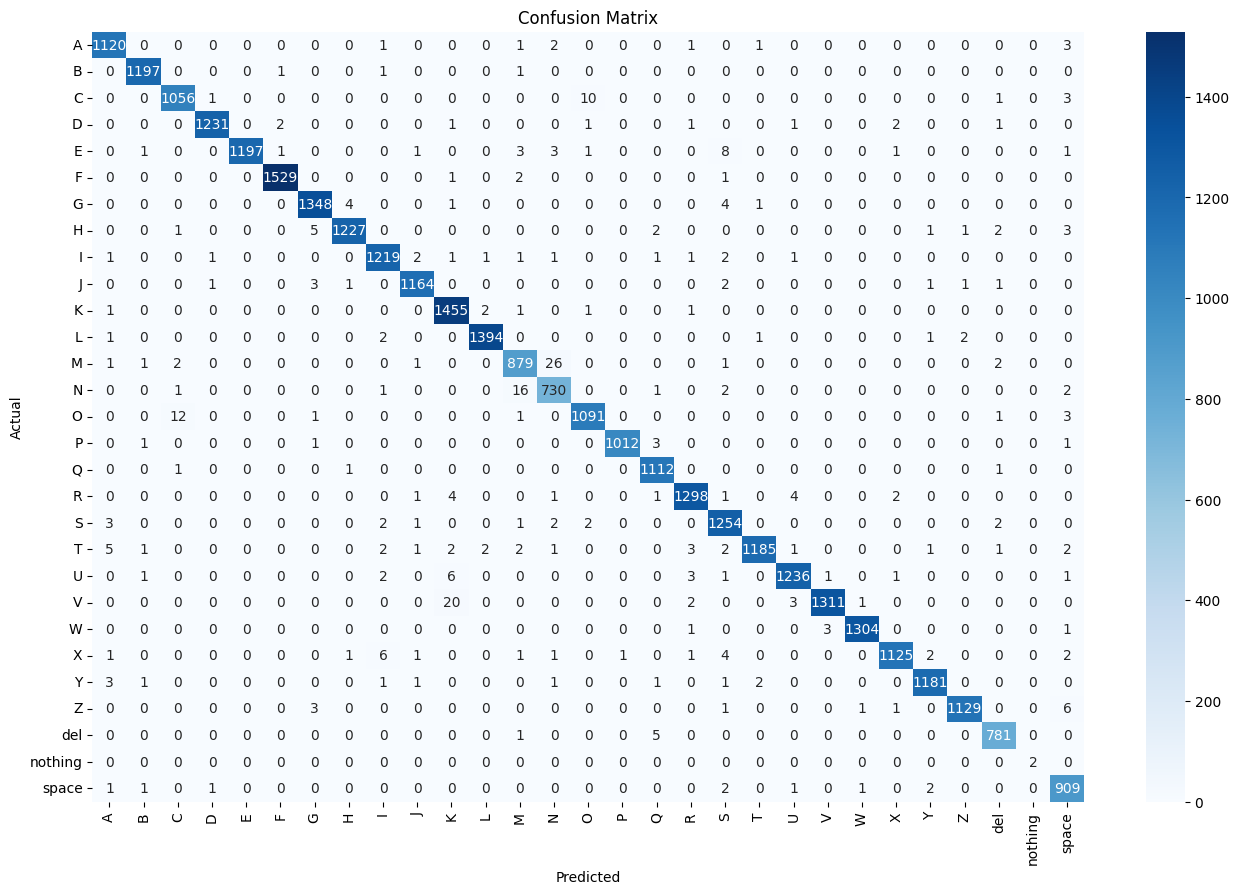

In [14]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(class_report)


              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1129
           B       0.99      1.00      1.00      1200
           C       0.98      0.99      0.99      1071
           D       1.00      0.99      0.99      1240
           E       1.00      0.98      0.99      1217
           F       1.00      1.00      1.00      1533
           G       0.99      0.99      0.99      1358
           H       0.99      0.99      0.99      1242
           I       0.99      0.99      0.99      1232
           J       0.99      0.99      0.99      1174
           K       0.98      1.00      0.99      1461
           L       1.00      1.00      1.00      1401
           M       0.97      0.96      0.96       913
           N       0.95      0.97      0.96       753
           O       0.99      0.98      0.99      1109
           P       1.00      0.99      1.00      1018
           Q       0.99      1.00      0.99      1115
           R       0.99    